In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
import missingno as msno

%matplotlib inline

In [2]:
%ls

1_EDA_and_Cleaning.ipynb
2_Preprocessing_Dummies_Analysis_BaselineModel.ipynb
3_FeatureEng_ModelTuning_KaggleSubmissions_Metrics_Visualizations.ipynb


In [3]:
# Reading in the data (using local path due to location of this notebook)

train = pd.read_csv('../data/train_clean_2.csv', na_filter = False)
test = pd.read_csv('../data/test_clean_2.csv',   na_filter = False)

#Source: Sam Stack and 
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [4]:
train.shape

(2049, 80)

In [5]:
test.shape

(879, 79)

In [6]:
#train.info()

### Exploratory Visualizations

Checking that the NA values in the dataframes were not imported as null values:

In [7]:
train.isnull().sum()[train.isnull().sum() != 0].sort_values(ascending = False)

Series([], dtype: int64)

In [8]:
test.isnull().sum()[train.isnull().sum() != 0].sort_values(ascending = False)

Series([], dtype: int64)

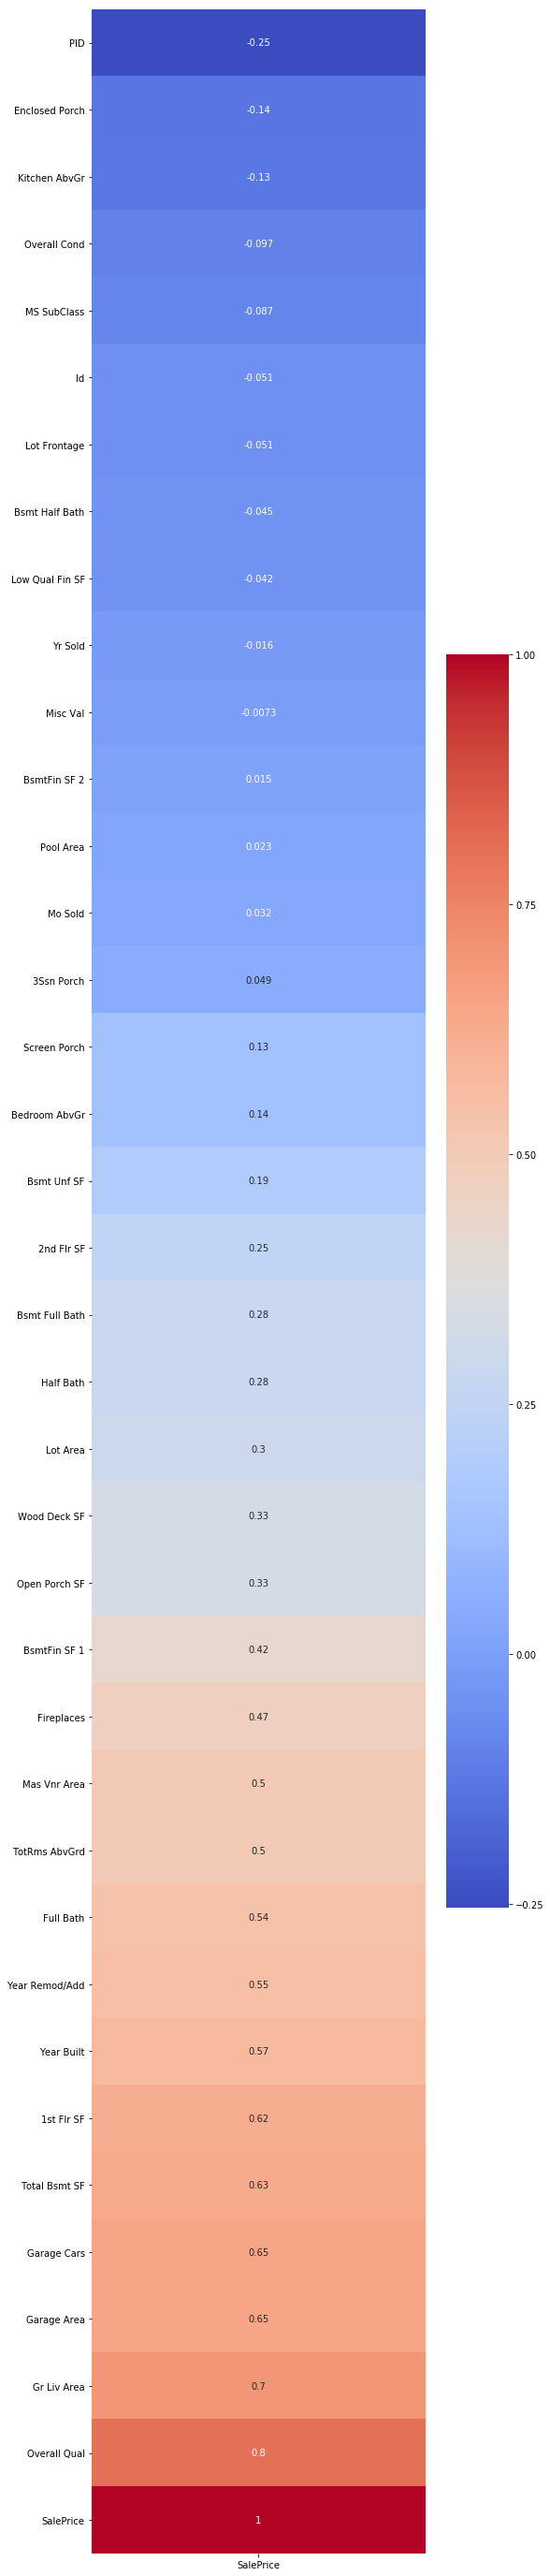

In [9]:
plt.figure(figsize = (8,50))
sns.heatmap(train.corr()[['SalePrice']].sort_values('SalePrice'), annot=True, cmap='coolwarm')

In [10]:
# select the float columns
train_floats = train.select_dtypes(include=[np.float])

#Source:
#https://stackoverflow.com/questions/21720022/find-all-columns-of-dataframe-in-
#pandas-whose-type-is-float-or-a-particular-typ

In [11]:
len(train_floats.columns)

9

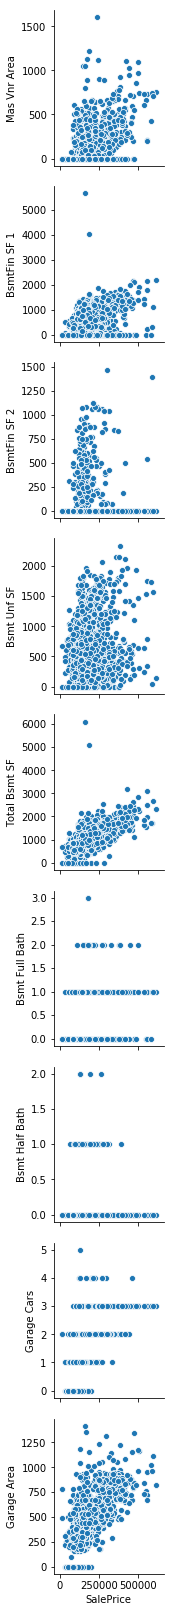

In [12]:
#Pairplot of columns with float types:
sns.pairplot(train, x_vars = 'SalePrice', y_vars = train_floats.columns)

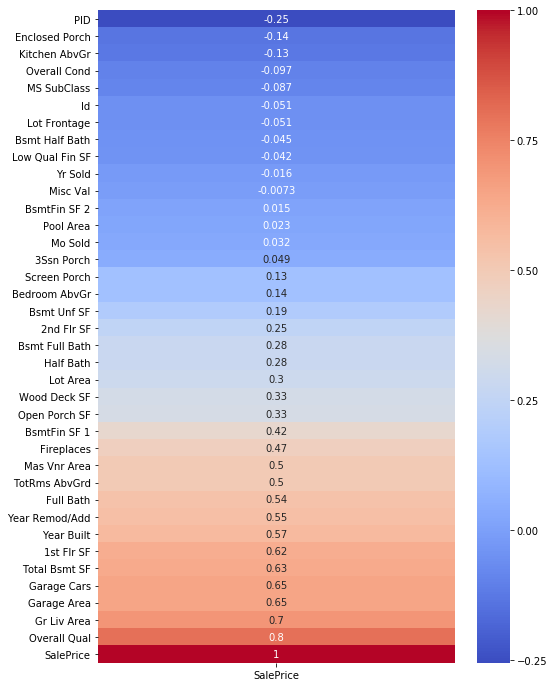

In [13]:
plt.figure(figsize = (8,12))
sns.heatmap(train.corr()[['SalePrice']].sort_values('SalePrice'), annot=True, cmap='coolwarm')

In [14]:
train_ints = train.select_dtypes(int)

In [15]:
train_ints.columns.shape

(29,)

In [16]:
train_ints.columns

Index(['Id', 'PID', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd',
       'Fireplaces', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
       '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold',
       'Yr Sold', 'SalePrice'],
      dtype='object')

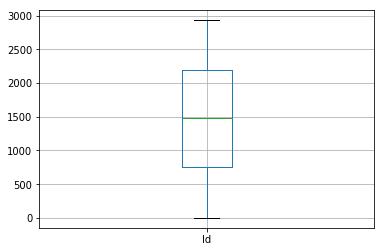

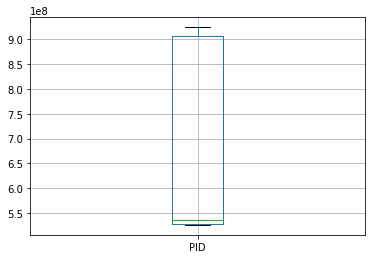

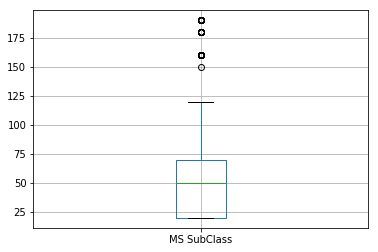

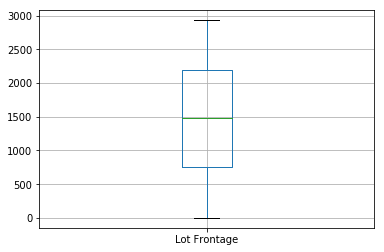

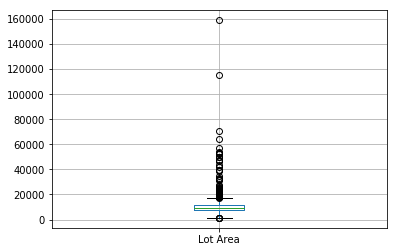

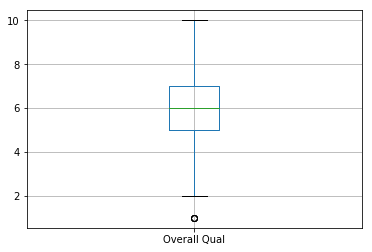

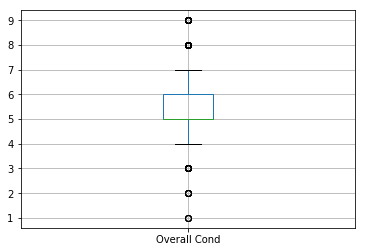

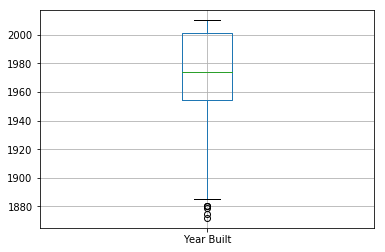

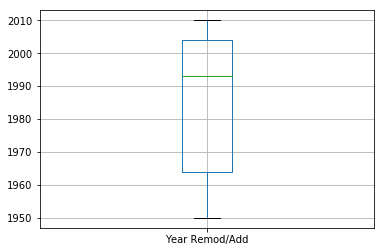

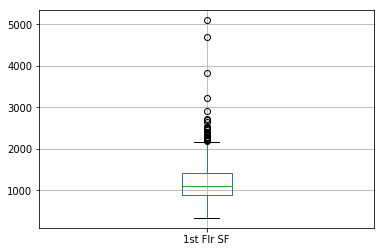

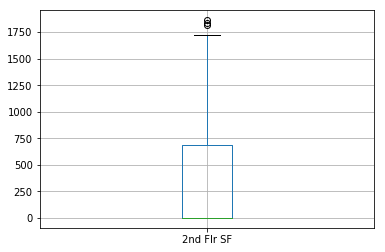

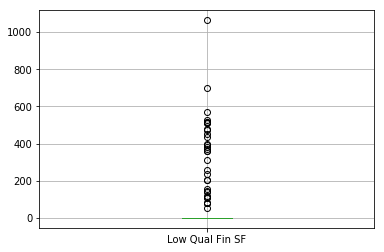

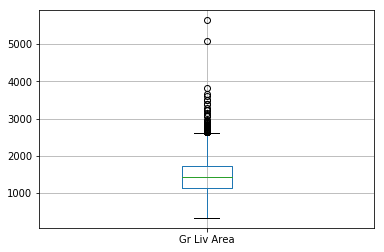

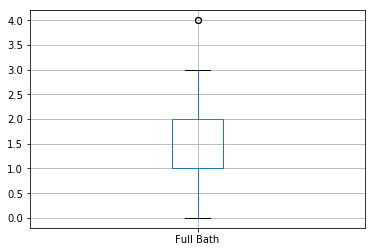

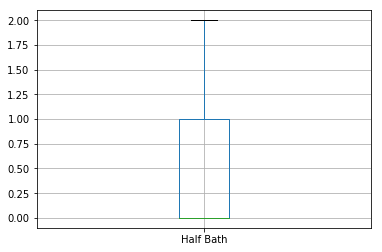

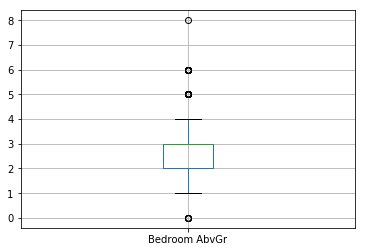

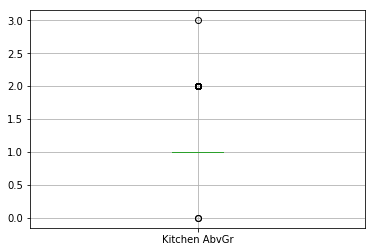

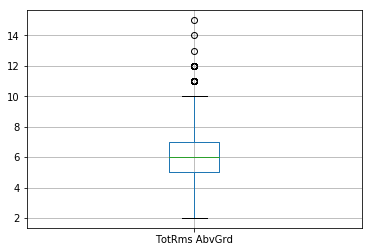

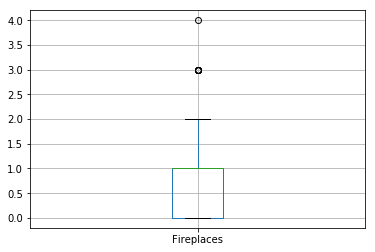

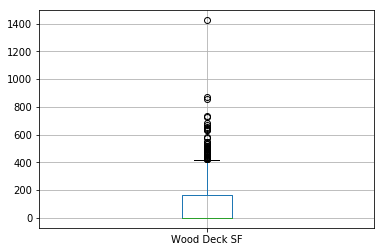

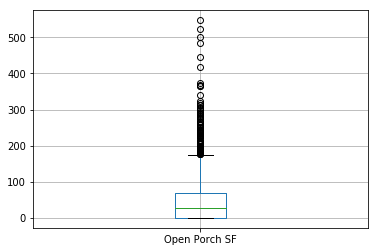

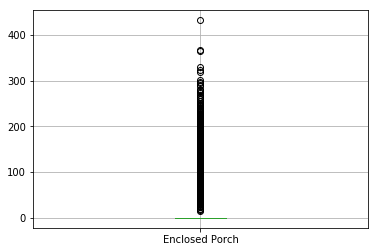

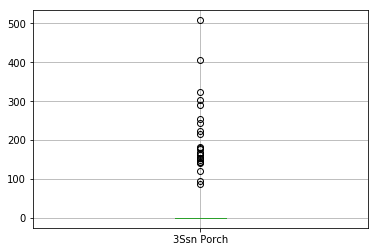

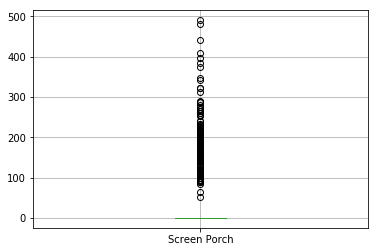

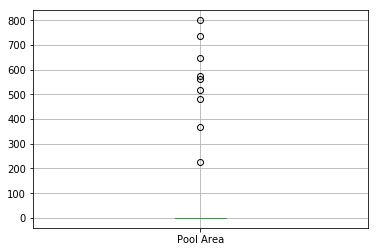

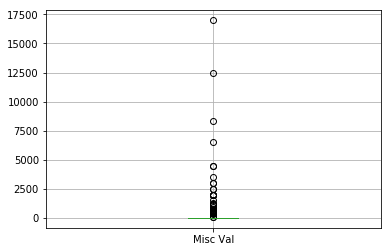

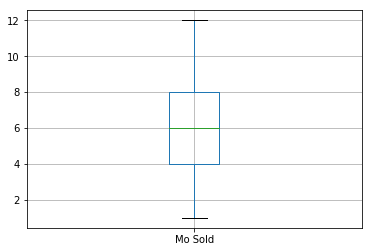

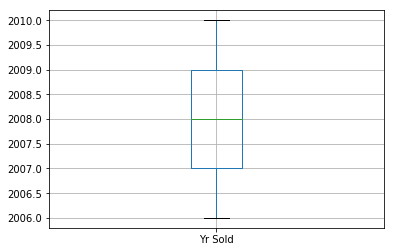

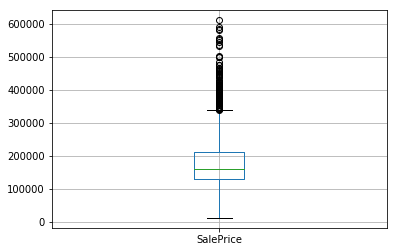

In [17]:
for i in range(len(train_ints.columns)):
    train[train_ints.columns[i:(i+1)]].boxplot()
    plt.show()

In [18]:
train_objs = train.select_dtypes(object)

In [19]:
train_objs.columns.shape

(42,)

In [20]:
train_objs.columns

Index(['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour',
       'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual',
       'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature',
       'Sale Type'],
      dtype='object')

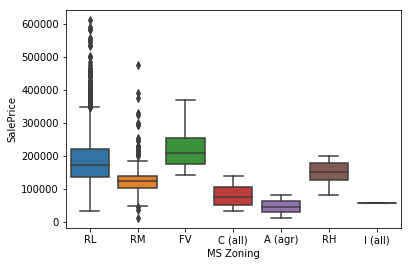

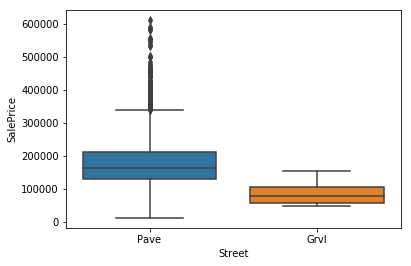

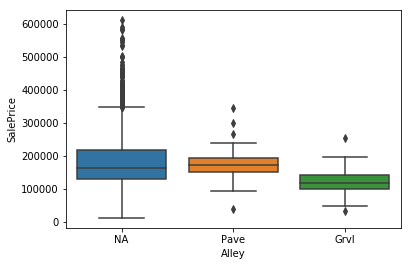

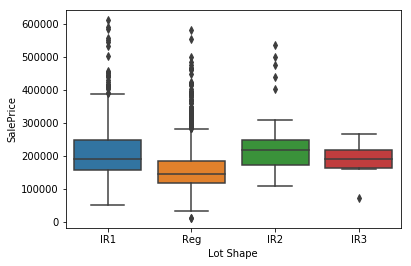

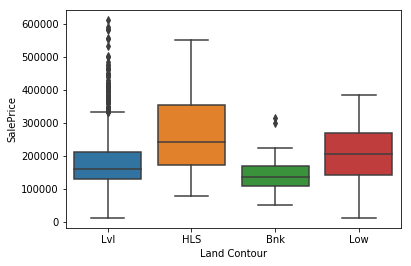

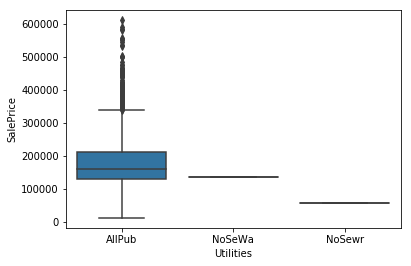

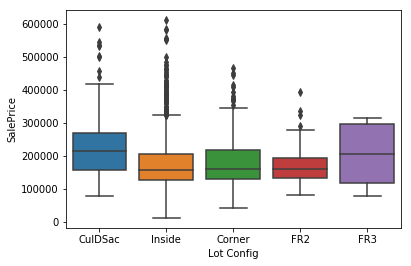

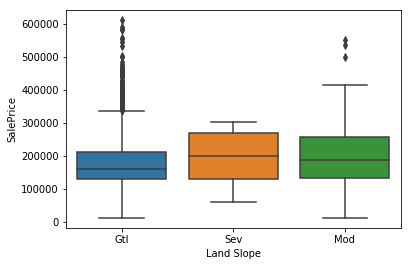

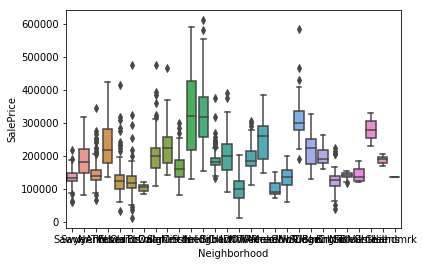

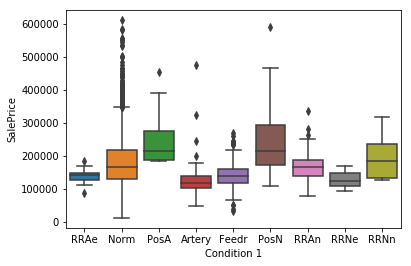

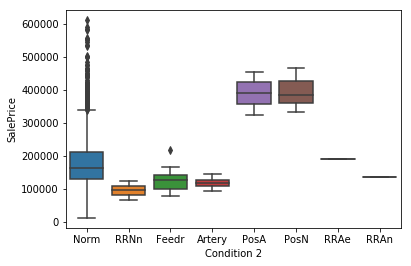

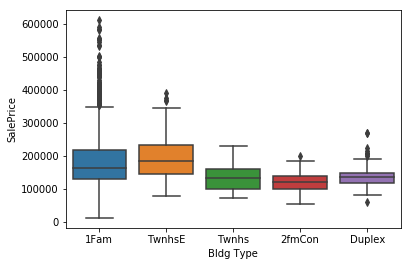

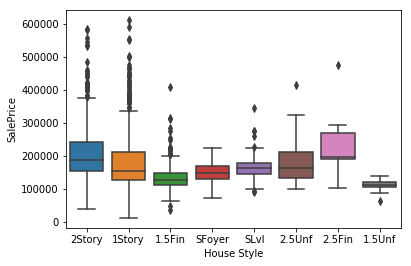

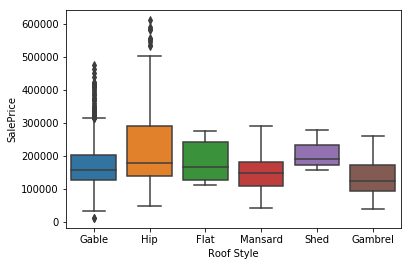

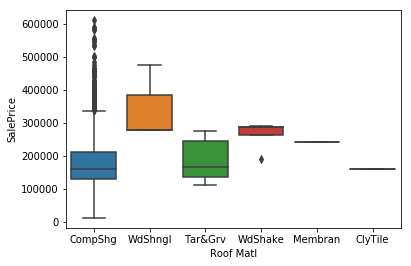

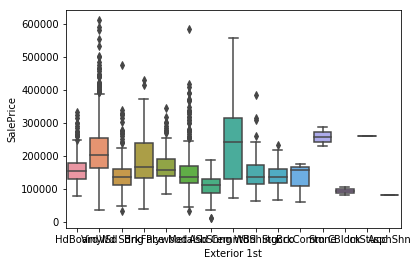

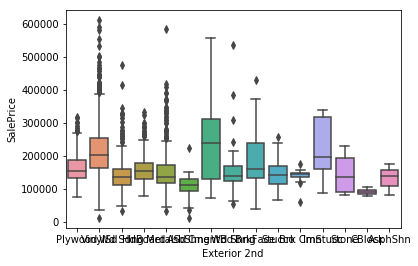

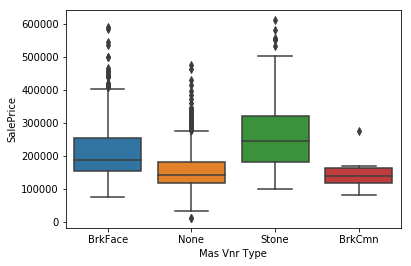

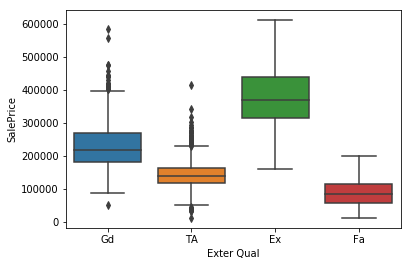

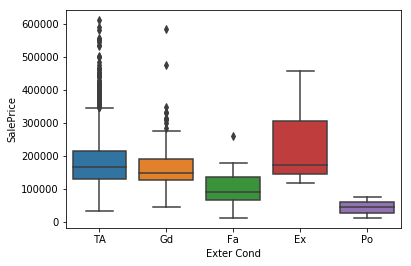

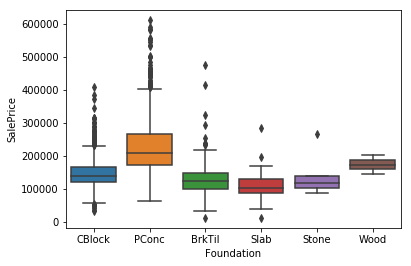

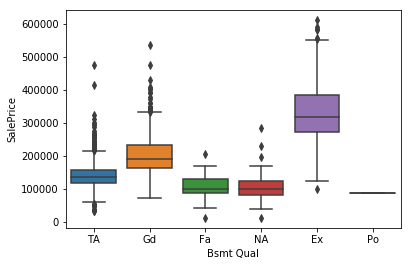

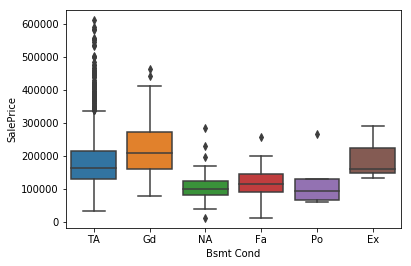

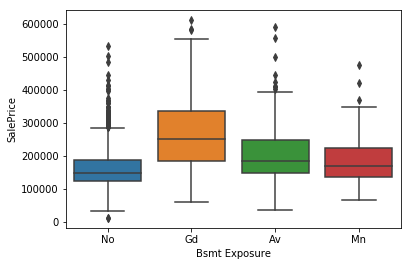

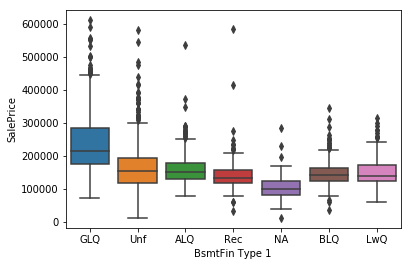

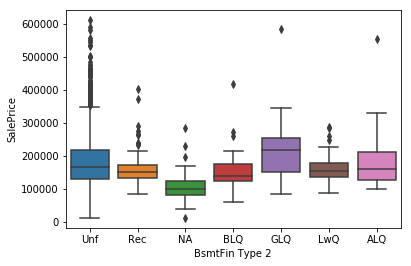

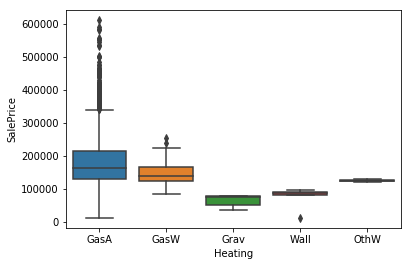

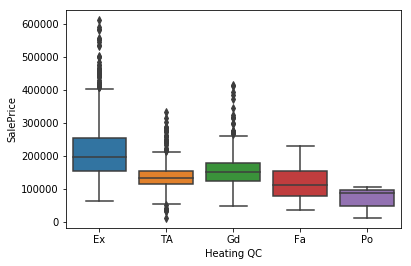

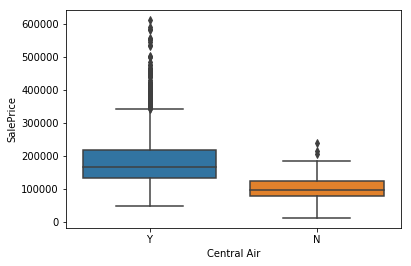

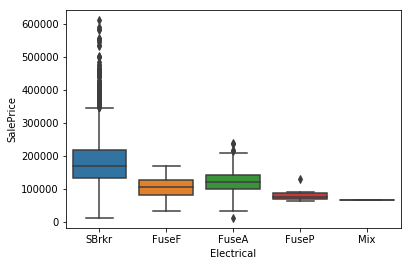

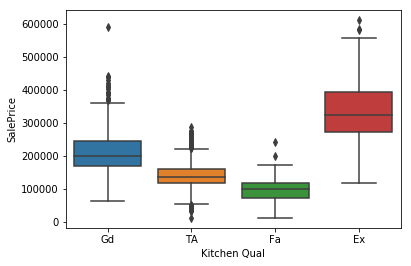

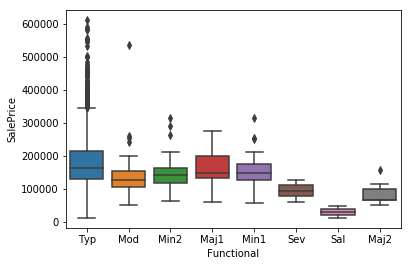

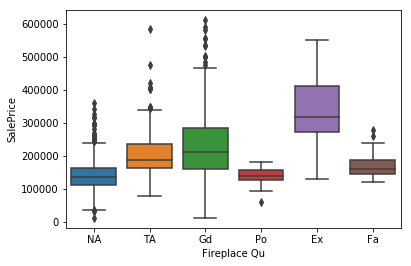

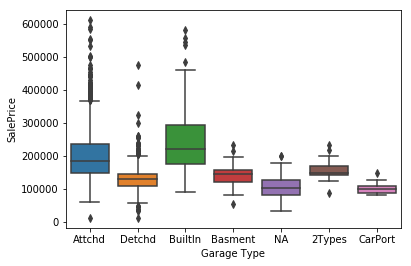

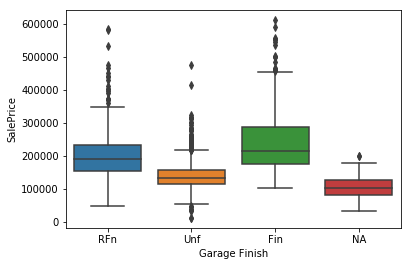

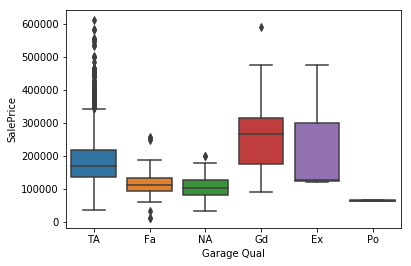

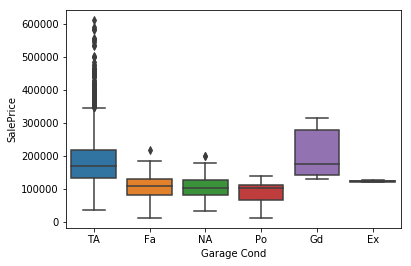

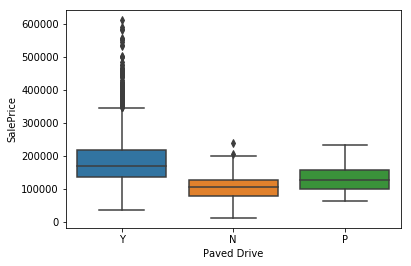

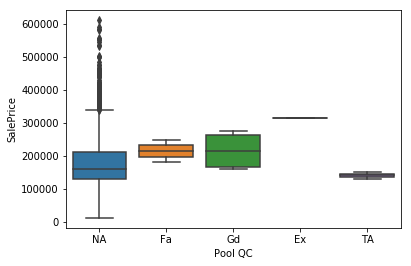

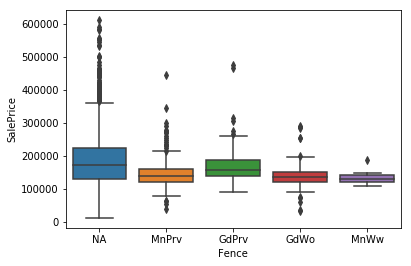

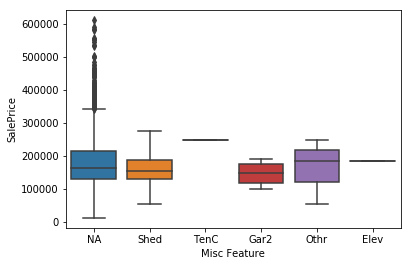

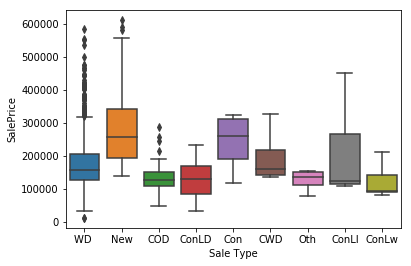

In [21]:
for i in range(len(train_objs.columns)):
    sns.boxplot(x = train_objs.columns[i], y='SalePrice', data = train, dodge=False)
    plt.show()

### Pre-Processing Data

#### One-hot encoding categorical variables

In [22]:
len(train_objs.columns)

42

In [23]:
most_val_list = [] # list to add category with most counts
for col in train_objs.columns:
    most_val = train[col].value_counts().index[0] # value count for each column, extracing the actual name
    dum_name = col+'_'+most_val # string concat it into fashion dummies will use
    most_val_list.append(dum_name) #add suspected column name to the list
    
#Source: Sam Stack
#https://git.generalassemb.ly/DSI-US-7/DEN-Flex/blob/master/Week-03/
#2-Supervised-Learning-Review/DummiesDropMost.ipynb    

In [24]:
len(most_val_list)

42

In [25]:
#Making sure can look at all columns when do df.head()
pd.set_option("display.max_columns",100)

In [26]:
train_df_dum = pd.get_dummies(train)

print(train_df_dum.shape) 

train_df_dum.head()

(2049, 304)


,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_NA,Alley_Pave,...,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_NA,Garage Finish_Fin,Garage Finish_NA,Garage Finish_RFn,Garage Finish_Unf,Garage Qual_Ex,Garage Qual_Fa,Garage Qual_Gd,Garage Qual_NA,Garage Qual_Po,Garage Qual_TA,Garage Cond_Ex,Garage Cond_Fa,Garage Cond_Gd,Garage Cond_NA,Garage Cond_Po,Garage Cond_TA,Paved Drive_N,Paved Drive_P,Paved Drive_Y,Pool QC_Ex,Pool QC_Fa,Pool QC_Gd,Pool QC_NA,Pool QC_TA,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NA,Misc Feature_Elev,Misc Feature_Gar2,Misc Feature_NA,Misc Feature_Othr,Misc Feature_Shed,Misc Feature_TenC,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
0,109,533352170,60,109,13517,6,8,1976,2005,289.0,533.0,0.0,192.0,725.0,725,754,0,1479,0.0,0.0,2,1,3,1,6,0,2.0,475.0,0,44,0,0,0,0,0,3,2010,130500,0,0,0,0,0,1,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,544,531379050,60,544,11492,7,5,1996,1997,132.0,637.0,0.0,276.0,913.0,913,1209,0,2122,1.0,0.0,2,1,4,1,8,1,2.0,559.0,0,74,0,0,0,0,0,4,2009,220000,0,0,0,0,0,1,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,153,535304180,20,153,7922,5,7,1953,2007,0.0,731.0,0.0,326.0,1057.0,1057,0,0,1057,1.0,0.0,1,0,3,1,5,0,1.0,246.0,0,52,0,0,0,0,0,1,2010,109000,0,0,0,0,0,1,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,318,916386060,60,318,9802,5,5,2006,2007,0.0,0.0,0.0,384.0,384.0,744,700,0,1444,0.0,0.0,2,1,3,1,7,0,2.0,400.0,100,0,0,0,0,0,0,4,2010,174000,0,0,0,0,0,1,0,0,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,255,906425045,50,255,14235,6,8,1900,1993,0.0,0.0,0.0,676.0,676.0,831,614,0,1445,0.0,0.0,2,0,3,1,6,0,2.0,484.0,0,59,0,0,0,0,0,3,2010,138500,0,0,0,0,0,1,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [27]:
#Getting rid of one dummy column per dummied variable to reduce risk of collinearity
#Dropping the columns that have the highest values counts to make the more unique values stand out
#to improve model prediction
train_dropped_colin = train_df_dum.drop(most_val_list, axis = 1) 

print(train_dropped_colin.shape) # look at shape and head after.
train_dropped_colin.head()

#Source: Sam Stack
#https://git.generalassemb.ly/DSI-US-7/DEN-Flex/blob/master/Week-03/
#2-Supervised-Learning-Review/DummiesDropMost.ipynb 

(2049, 262)


,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RM,Street_Grvl,Alley_Grvl,Alley_Pave,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,...,Functional_Mod,Functional_Sal,Functional_Sev,Fireplace Qu_Ex,Fireplace Qu_Fa,Fireplace Qu_Gd,Fireplace Qu_Po,Fireplace Qu_TA,Garage Type_2Types,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_NA,Garage Finish_Fin,Garage Finish_NA,Garage Finish_RFn,Garage Qual_Ex,Garage Qual_Fa,Garage Qual_Gd,Garage Qual_NA,Garage Qual_Po,Garage Cond_Ex,Garage Cond_Fa,Garage Cond_Gd,Garage Cond_NA,Garage Cond_Po,Paved Drive_N,Paved Drive_P,Pool QC_Ex,Pool QC_Fa,Pool QC_Gd,Pool QC_TA,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Misc Feature_Elev,Misc Feature_Gar2,Misc Feature_Othr,Misc Feature_Shed,Misc Feature_TenC,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth
0,109,533352170,60,109,13517,6,8,1976,2005,289.0,533.0,0.0,192.0,725.0,725,754,0,1479,0.0,0.0,2,1,3,1,6,0,2.0,475.0,0,44,0,0,0,0,0,3,2010,130500,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,544,531379050,60,544,11492,7,5,1996,1997,132.0,637.0,0.0,276.0,913.0,913,1209,0,2122,1.0,0.0,2,1,4,1,8,1,2.0,559.0,0,74,0,0,0,0,0,4,2009,220000,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,153,535304180,20,153,7922,5,7,1953,2007,0.0,731.0,0.0,326.0,1057.0,1057,0,0,1057,1.0,0.0,1,0,3,1,5,0,1.0,246.0,0,52,0,0,0,0,0,1,2010,109000,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,318,916386060,60,318,9802,5,5,2006,2007,0.0,0.0,0.0,384.0,384.0,744,700,0,1444,0.0,0.0,2,1,3,1,7,0,2.0,400.0,100,0,0,0,0,0,0,4,2010,174000,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,255,906425045,50,255,14235,6,8,1900,1993,0.0,0.0,0.0,676.0,676.0,831,614,0,1445,0.0,0.0,2,0,3,1,6,0,2.0,484.0,0,59,0,0,0,0,0,3,2010,138500,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


There are dummy variable columns for NA values found in categorical values.

In [28]:
test_objs = test.select_dtypes(object)

In [29]:
len(test_objs.columns)

41

In [30]:
# most_val_list_t = [] # list to add category with most counts
# for col in test_objs.columns:
#     most_val_t = test[col].value_counts().index[0] # value count for each column, extracing the actual name
#     dum_name_t = col+'_'+most_val_t # string concat it into fashion dummies will use
#     most_val_list_t.append(dum_name_t) #add suspected column name to the list
    
# #Source: Sam Stack
# #https://git.generalassemb.ly/DSI-US-7/DEN-Flex/blob/master/Week-03/
# #2-Supervised-Learning-Review/DummiesDropMost.ipynb 

In [31]:
#len(most_val_list_t)

In [32]:
test_df_dum  = pd.get_dummies(test)

print(test_df_dum.shape)

test_df_dum.head()

(879, 283)


,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_NA,Alley_Pave,Lot Shape_IR1,...,Fireplace Qu_NA,Fireplace Qu_Po,Fireplace Qu_TA,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_NA,Garage Finish_Fin,Garage Finish_NA,Garage Finish_RFn,Garage Finish_Unf,Garage Qual_Fa,Garage Qual_Gd,Garage Qual_NA,Garage Qual_Po,Garage Qual_TA,Garage Cond_Ex,Garage Cond_Fa,Garage Cond_Gd,Garage Cond_NA,Garage Cond_Po,Garage Cond_TA,Paved Drive_N,Paved Drive_P,Paved Drive_Y,Pool QC_Ex,Pool QC_NA,Pool QC_TA,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NA,Misc Feature_Gar2,Misc Feature_NA,Misc Feature_Othr,Misc Feature_Shed,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD
0,2658,902301120,190,2658.0,9142,6,8,1910,1950,0.0,0,0,1020,1020,2658,908,1020,0,1928,0,0,2,0,4,2,9,0,1,440,0,60,112,0,0,0,0,4,2006,0,0,0,0,0,1,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,2718,905108090,90,2718.0,9662,5,4,1977,1977,0.0,0,0,1967,1967,2718,1967,0,0,1967,0,0,2,0,6,2,10,0,2,580,170,0,0,0,0,0,0,8,2006,0,0,0,0,1,0,0,1,0,1,0,1,...,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,2414,528218130,60,2414.0,17104,7,5,2006,2006,0.0,554,0,100,654,2414,664,832,0,1496,1,0,2,1,3,1,7,1,2,426,100,24,0,0,0,0,0,9,2006,0,0,0,0,1,0,0,1,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,1989,902207150,30,1989.0,8520,5,6,1923,2006,0.0,0,0,968,968,1989,968,0,0,968,0,0,1,0,2,1,5,0,2,480,0,0,184,0,0,0,0,7,2007,0,0,0,0,0,1,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,625,535105100,20,625.0,9500,6,5,1963,1963,247.0,609,0,785,1394,625,1394,0,0,1394,1,0,1,1,3,1,6,2,2,514,0,76,0,0,185,0,0,7,2009,0,0,0,0,1,0,0,1,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [33]:
test_df_dum.shape[0]

879

In [34]:
test_df_dum['Electrical_SBrkr'] = [0]*test_df_dum.shape[0]

In [35]:
#Getting rid of one dummy column per dummied variable to reduce risk of collinearity
#Dropping the columns that have the highest values counts to make the more unique values stand out
#to improve model prediction
test_dropped_colin = test_df_dum.drop(most_val_list, axis = 1) 

print(test_dropped_colin.shape) # look at shape and head after.
test_dropped_colin.head()

#Source: Sam Stack
#https://git.generalassemb.ly/DSI-US-7/DEN-Flex/blob/master/Week-03/
#2-Supervised-Learning-Review/DummiesDropMost.ipynb 

(879, 242)


,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RM,Street_Grvl,Alley_Grvl,Alley_Pave,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Land Contour_Bnk,...,Kitchen Qual_Gd,Kitchen Qual_Po,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Fireplace Qu_Ex,Fireplace Qu_Fa,Fireplace Qu_Gd,Fireplace Qu_Po,Fireplace Qu_TA,Garage Type_2Types,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_NA,Garage Finish_Fin,Garage Finish_NA,Garage Finish_RFn,Garage Qual_Fa,Garage Qual_Gd,Garage Qual_NA,Garage Qual_Po,Garage Cond_Ex,Garage Cond_Fa,Garage Cond_Gd,Garage Cond_NA,Garage Cond_Po,Paved Drive_N,Paved Drive_P,Pool QC_Ex,Pool QC_TA,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Misc Feature_Gar2,Misc Feature_Othr,Misc Feature_Shed,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD
0,2658,902301120,190,2658.0,9142,6,8,1910,1950,0.0,0,0,1020,1020,2658,908,1020,0,1928,0,0,2,0,4,2,9,0,1,440,0,60,112,0,0,0,0,4,2006,0,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2718,905108090,90,2718.0,9662,5,4,1977,1977,0.0,0,0,1967,1967,2718,1967,0,0,1967,0,0,2,0,6,2,10,0,2,580,170,0,0,0,0,0,0,8,2006,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2414,528218130,60,2414.0,17104,7,5,2006,2006,0.0,554,0,100,654,2414,664,832,0,1496,1,0,2,1,3,1,7,1,2,426,100,24,0,0,0,0,0,9,2006,0,0,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1989,902207150,30,1989.0,8520,5,6,1923,2006,0.0,0,0,968,968,1989,968,0,0,968,0,0,1,0,2,1,5,0,2,480,0,0,184,0,0,0,0,7,2007,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,625,535105100,20,625.0,9500,6,5,1963,1963,247.0,609,0,785,1394,625,1394,0,0,1394,1,0,1,1,3,1,6,2,2,514,0,76,0,0,185,0,0,7,2009,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Making sure train and test sets have same columns (and the same number of columns):

In [36]:
#Finding the columns that are in the train_df_dum set but not the test_df_dum set:
cols_train_not_test=[]
for i in set(train_df_dum).difference(test_df_dum):
    cols_train_not_test.append(i)

#Finding the columns that are in the test_df_dum set but not the train_df_dum set:    
cols_test_not_train=[]
for i in set(test_df_dum).difference(train_df_dum):
    cols_test_not_train.append(i)

#Source:
#https://www.geeksforgeeks.org/python-find-missing-additional-values-two-lists/

In [37]:
#Checking values:
cols_train_not_test

['Exterior 2nd_Stone',
 'MS Zoning_A (agr)',
 'Misc Feature_Elev',
 'Functional_Sev',
 'SalePrice',
 'Functional_Sal',
 'Neighborhood_GrnHill',
 'Bsmt Cond_Ex',
 'Neighborhood_Landmrk',
 'Heating_Wall',
 'Exterior 1st_CBlock',
 'Utilities_NoSeWa',
 'Condition 2_RRNn',
 'Roof Matl_ClyTile',
 'Garage Qual_Ex',
 'Pool QC_Gd',
 'Bsmt Cond_Po',
 'Electrical_FuseF',
 'Condition 2_RRAe',
 'Heating QC_Po',
 'Roof Matl_Membran',
 'Pool QC_Fa',
 'Exterior 1st_ImStucc',
 'Condition 2_RRAn',
 'Condition 2_Artery',
 'Electrical_FuseA',
 'Electrical_Mix',
 'Misc Feature_TenC',
 'Electrical_FuseP',
 'Heating_OthW',
 'Exterior 1st_Stone']

In [38]:
#Checking values
cols_test_not_train

['Kitchen Qual_Po',
 'Mas Vnr Type_CBlock',
 'Exterior 2nd_Other',
 'Exterior 2nd_PreCast',
 'Electrical',
 'Roof Matl_Metal',
 'Roof Matl_Roll',
 'Heating_Floor',
 'Exterior 1st_PreCast',
 'Bsmt Exposure_NA',
 'Sale Type_VWD']

In [39]:
#Placing columns that are in train_df_dum but not test_df_dum into test_df_dum set (columns filled with 0's):
for col_name in cols_train_not_test:
    test_df_dum[col_name] = [0]*test_df_dum.shape[0]

#Placing columns that are in test_df_dum but not train_df_dum into test_df_dum set (columns filled with 0's):
for col_name in cols_test_not_train:
    train_df_dum[col_name] = [0]*train_df_dum.shape[0]
    
#Source:
#https://stackoverflow.com/questions/8528178/list-of-zeros-in-python

In [40]:
#Checking work:
cols_train_not_test=[]
for i in set(train_df_dum).difference(test_df_dum):
    cols_train_not_test.append(i)

cols_test_not_train=[]
for i in set(test_df_dum).difference(train_df_dum):
    cols_test_not_train.append(i)
    
print(cols_train_not_test)
print(cols_test_not_train)

[]
[]


In [41]:
#Checking train_df_dum number of columns:
train_df_dum.shape

(2049, 315)

In [42]:
#Checking test_df_dum number of columns:
test_df_dum.shape

(879, 315)

In [43]:
#Making sure SalePrice not in test dataset
test_df_dum = test_df_dum.drop(columns = 'SalePrice')

In [44]:
#Checking test_df_dum number of columns:
test_df_dum.shape

(879, 314)

In [45]:
X = train_df_dum.drop(columns = 'SalePrice')
y = train_df_dum['SalePrice']

In [46]:
X.shape

(2049, 314)

In [47]:
y.shape

(2049,)

### Train/test splitting data

In [48]:
#Using 70% of data for training and 30% of data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state=42)

### Scaling data using PowerTransformer (scales after transforms data)

There is a need to transform data because there is heteroscedasticity, and the target variable data has a skew in its distribution, as shown below.

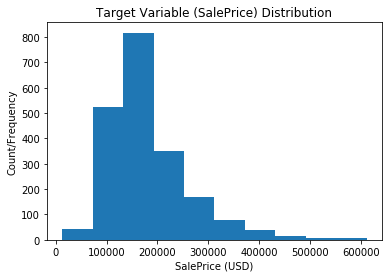

In [49]:
plt.hist(y);
plt.title('Target Variable (SalePrice) Distribution');
plt.xlabel('SalePrice (USD)');
plt.ylabel('Count/Frequency');

Transforming feature data

In [50]:
#Instantiating PowerTransformer for X variables:
pt = PowerTransformer()

pt.fit(X_train)
X_train_pt = pt.transform(X_train)
X_test_pt = pt.transform(X_test)

X_test_Kaggle = test_df_dum
X_Kaggle_pt = pt.transform(X_test_Kaggle)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2798: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [51]:
#Instantiating PowerTransformer for y variables:
pt_y = PowerTransformer()

# PowerTransformer requires a matrix/DataFrame, which is why we're using the .to_frame() method on y_train
pt_y.fit(y_train.to_frame()) 
y_train_pt = pt_y.transform(y_train.to_frame())
y_test_pt = pt_y.transform(y_test.to_frame())

### Modeling

#### Model 1 (The Baseline:  A linear regression model with all variables used as features to create model)

In [52]:
#Instantiating Linear Regression Model
lr = LinearRegression()

In [53]:
lr.fit(X_train_pt, y_train_pt)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [54]:
lr_preds = lr.predict(X_test_pt)

In [55]:
#lr.coef_

There are a lot of coefficients with large exponential values, and these are likely negatively affecting model accuracy.

In [56]:
lr.intercept_

array([0.00715472])

The intercept of approx. 0.00715 appears to be reasonable.  When all features equal 0, it seems reasonable that the SalePrice could be approx. $0.01.

In [57]:
lr_cv_scores = cross_val_score(lr, X_train_pt, y_train_pt, cv=5)
lr_cv_scores.mean()

-5.201819090550247e+25

In [58]:
lr_train_score = lr.score(X_train_pt, y_train_pt)
lr_train_score

0.953547709017359

In [59]:
lr_test_score = lr.score(X_test_pt, y_test_pt)
lr_test_score

-7.335250504413271e+25

In [60]:
# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lr_checking = pt_y.inverse_transform(lr_preds.reshape(-1,1))

#Source: Riley Dallas helped with this

In [61]:
y_test.shape

(615,)

In [62]:
pred_reversed_lr_checking.shape

(615, 1)

In [63]:
lr_rev_test_score = r2_score(y_test, pred_reversed_lr_checking)

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/regression.py:543: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


There seems to be a major issue with the inverse transform of the PowerTransform. 

The high training score and very low cross-validation (CV) score and test score show, as expected when using all 314 features in train_df_dum's training subset to create a model, that this model is very overfit.

Predicting test data for Kaggle Submission:

In [64]:
X_Kaggle_pt.shape

(879, 314)

In [65]:
lr_preds_Kaggle = lr.predict(X_Kaggle_pt)

In [66]:
lr_preds_Kaggle.shape

(879, 1)

In [67]:
#lr_preds_Kaggle

In [68]:
# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lr = pt_y.inverse_transform(lr_preds_Kaggle.reshape(-1,1))

In [69]:
#pred_reversed_lr

In [70]:
submission = test_df_dum[['Id']]
submission['SalePrice'] = pred_reversed_lr

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [71]:
submission.head()

,Id,SalePrice
0,2658,2.104108e+171
1,2718,1.605532e+170
2,2414,1.784421e+179
3,1989,2.391728e+170
4,625,3.731192e+177


In [72]:
submission.shape

(879, 2)

In [73]:
#When forgot to reverse-transform the predictions:
submission.to_csv('../data/submissions/submission_lr_1.csv', index = False)

When forgot to reverse-transform the predictions:
Score got on Kaggle (when forgot to reverse the PowerTransform on the predictions): 50880906856961.60000

In [74]:
#When remembered to reverse-transform the predictions:
submission.to_csv('../data/submissions/submission_lr_model_1_InvTrans.csv', index = False)

When submitted inverse-transformed predictions:
The Kaggle submission failed: Submission had an invalid score. Please check your input data for numerical errors (e.g. "NaN", division by zero, etc)

This is likely because there were issues with the reverse transform (the values became huge and probably hard for the Kaggle system to handle).

#### Model 2: The baseline model (all variables used as features) but utilizing LassoCV to reduce coefficients of less important features

In [75]:
#Instantiating LassoCV using 200 alphas to optimize over and 5 cross-validation folds:
lasso = LassoCV(n_alphas=200, cv=5)

lasso.fit(X_train_pt, y_train_pt[:, 0])

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=200, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [76]:
lasso_preds = lasso.predict(X_test_pt)

In [77]:
#lasso.coef_

The coefficients look much less extreme than those in LinearRegression when the model is fit using LassoCV.

In [78]:
lasso.intercept_

6.450010821358999e-16

The intercept seems reasonable.  As all feature values approach zero, it makes sense for the SalePrice to approach zero.

In [79]:
lasso_cv_scores = cross_val_score(lasso, X_train_pt, y_train_pt[:, 0], cv=5)
lasso_cv_scores.mean()

0.8933369906142057

In [80]:
lasso_score_train = lasso.score(X_train_pt, y_train_pt)
lasso_score_train

0.9449698516797945

In [81]:
lasso_score_test = lasso.score(X_test_pt, y_test_pt)
lasso_score_test

0.9153134942388907

In [82]:
# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lasso_checking = pt_y.inverse_transform(lasso_preds.reshape(-1,1))

In [83]:
#pred_reversed_lasso_checking

In [84]:
lasso_score_rev_test = r2_score(y_test, pred_reversed_lasso_checking)

The cross-validation score and the test score look much better (while the train score slightly decreased), and the train score and test score are much closer to each other.  The train score is still quite a bit larger than the CV score.  The model is still pretty overfit, and the model is not as consistent over different CV folds as hoped.
When the predictions were reverse-transformed, the test score increased and got much closer to the train score!  That's good!

In [85]:
lasso_preds_Kaggle = lasso.predict(X_Kaggle_pt)

In [86]:
# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_lasso_Kaggle = pt_y.inverse_transform(lasso_preds_Kaggle.reshape(-1,1))

In [87]:
#pred_reversed_lasso_Kaggle

In [88]:
#When forgot to reverse-transform the prediction values:
submission = test_df_dum[['Id']]
submission['SalePrice'] = lasso_preds_Kaggle

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [89]:
submission.head()

,Id,SalePrice
0,2658,-8.789619
1,2718,-9.811464
2,2414,-7.389360
3,1989,-8.609973
4,625,-8.310518


In [90]:
submission.shape

(879, 2)

In [91]:
submission.to_csv('../data/submissions/submission_lasso_model_2.csv', index = False)

Score got on Kaggle: 197810.63199

In [92]:
#When remembered to reverse-transform the prediction values:
submission = test_df_dum[['Id']]
submission['SalePrice'] = pred_reversed_lasso_Kaggle

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [93]:
submission.head()

,Id,SalePrice
0,2658,2624.165799
1,2718,1481.133631
2,2414,5543.662571
3,1989,2894.923035
4,625,3404.638306


In [94]:
submission.shape

(879, 2)

In [95]:
submission.to_csv('../data/submissions/submission_lasso_InvTrans_model_2.csv', index = False)

Score got on Kaggle: 194344.43060

#### Model 3: The baseline model (all variables used as features) but utilizing RidgeCV to reduce coefficients of less important features

In [97]:
#Instantiating RidgeCV using 200 alphas to optimize over and 5 cross-validation folds:
ridge = RidgeCV(alphas = np.linspace(0.01, 10, 100))

ridge.fit(X_train_pt, y_train_pt)

RidgeCV(alphas=array([ 0.01   ,  0.11091, ...,  9.89909, 10.     ]), cv=None,
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [98]:
ridge_preds = ridge.predict(X_test_pt)

In [99]:
#ridge.coef_

The coefficients look much less extreme than those in LinearRegression when the model is fit using RidgeCV.

In [100]:
lasso.intercept_

6.450010821358999e-16

The intercept seems reasonable.  As all feature values approach zero, it makes sense for the SalePrice to approach zero.

In [101]:
ridge_cv_scores = cross_val_score(ridge, X_train_pt, y_train_pt, cv=5)
ridge_cv_scores.mean()

0.8829160682111308

In [102]:
ridge_train_score = ridge.score(X_train_pt, y_train_pt)
ridge_train_score

0.9535243398091182

In [103]:
ridge_test_score = ridge.score(X_test_pt, y_test_pt)
ridge_test_score

0.9040045774691559

In [104]:
# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_ridge_checking = pt_y.inverse_transform(ridge_preds.reshape(-1,1))

In [105]:
#pred_reversed_ridge_checking

In [106]:
ridge_test_rev_score = r2_score(y_test, pred_reversed_ridge_checking)
ridge_test_rev_score

0.9377776427904749

The cross-validation score decreased slightly, the train score increased slightly, and the test score decreased slightly.  The train score and test score relatively close to each other.  The train score is still quite a bit larger than the CV score.  The model is still pretty overfit, and the model is not as consistent over different CV folds as hoped.
When the predictions were reverse-transformed, the test score increased and got much closer to the train score!  That's good!

In [107]:
ridge_preds_Kaggle = ridge.predict(X_Kaggle_pt)

In [108]:
#ridge_preds_Kaggle

In [109]:
# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_ridge_Kaggle = pt_y.inverse_transform(ridge_preds_Kaggle.reshape(-1,1))

In [110]:
#pred_reversed_ridge_Kaggle

These values do not look good (many are < 0 USD), so this model will not be submitted on Kaggle.

#### Model 4: The baseline model (all variables used as features) but utilizing ElasticNetCV to reduce coefficients of less important features

In [111]:
#Setting up array of potential l1 ratios 
enet_ratio = np.linspace(0.01, 1.0, 100)

#Instantiating model.
enet_model = ElasticNetCV(n_alphas = 100, l1_ratio = enet_ratio, cv = 3)

# Fit model using optimal alpha.
enet_model = enet_model.fit(X_train_pt, y_train_pt[:,0]) 

#Generating predictions.
enet_model_preds = enet_model.predict(X_test_pt)
enet_model_preds_train = enet_model.predict(X_train_pt)

#Reverse transforming predictions:
# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_enet_checking = pt_y.inverse_transform(enet_model_preds.reshape(-1,1))

#Finding cross-validation score:
enet_cv_scores = cross_val_score(enet_model, X_train_pt, y_train_pt[:,0], cv = 3)

#Evaluating model.
print(enet_model.alpha_)
print(enet_model.l1_ratio_)
print(enet_cv_scores.mean())
print(r2_score(y_test_pt, enet_model_preds))
print(r2_score(y_train_pt, enet_model_preds_train))
print(r2_score(y_test, pred_reversed_enet_checking))

0.08856414266682804
0.06999999999999999
0.8961881027770552
0.9119657534392898
0.9442655459228075
0.9347042363921853


In [112]:
scores = pd.DataFrame()
#(col_name = )
scores['R Squared Scores'] = ['CrossVal', 'Train_R2', 'Test_R2', 'Test_Rev_R2']
scores['LR_Baseline']      = [lr_cv_scores.mean(), lr_train_score, lr_test_score, lr_rev_test_score]
scores['LassoCV_Baseline'] = [lasso_cv_scores.mean(), lasso_score_train, lasso_score_test, lasso_score_rev_test]
scores['RidgeCV_Baseline'] = [ridge_cv_scores.mean(), ridge_train_score, ridge_test_score, ridge_test_rev_score]
scores['ElasticNet_Baseline'] = [enet_cv_scores.mean(), r2_score(y_train_pt, enet_model_preds_train),
                                 r2_score(y_test_pt, enet_model_preds), 
                                 r2_score(y_test, pred_reversed_enet_checking)]

scores

,R Squared Scores,LR_Baseline,LassoCV_Baseline,RidgeCV_Baseline,ElasticNet_Baseline
0,CrossVal,-5.201819e+25,0.893337,0.882916,0.896188
1,Train_R2,9.535477e-01,0.944970,0.953524,0.944266
2,Test_R2,-7.335251e+25,0.915313,0.904005,0.911966
3,Test_Rev_R2,-inf,0.940465,0.937778,0.934704


The scores for all baseline models created so far are summarized above. The model created using ElasticNetCV and all features (Power Transformed) has similar R squared scores to the LassoCV and RidgeCV models, but the cross-validation score is a bit higher, the training score is a bit lower, the test score is in the middle, and the test score after reversing the Power Transformation is a bit worse. 

In [113]:
enet_preds_Kaggle = enet_model.predict(X_Kaggle_pt)

In [114]:
#Checking work:
#enet_preds_Kaggle

In [115]:
# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed_enet_Kaggle = pt_y.inverse_transform(enet_preds_Kaggle.reshape(-1,1))

In [116]:
#pred_reversed_enet_Kaggle

In [117]:
#When remembered to reverse-transform the prediction values:
submission = test_df_dum[['Id']]
submission['SalePrice'] = pred_reversed_enet_Kaggle

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [118]:
submission.head()

,Id,SalePrice
0,2658,11833.945028
1,2718,6383.262532
2,2414,17733.432937
3,1989,11535.780240
4,625,10823.345862


In [119]:
#submission.describe()
submission.shape

(879, 2)

In [120]:
submission.to_csv('../data/submissions/submission_enet_InvTrans_model_4.csv', index = False)

Score got on Kaggle: 187343.51582

In [121]:
train_df_dum.shape

(2049, 315)

In [122]:
test_df_dum.shape

(879, 314)

Saving training and testing dataframes to csv files so they can be imported easily in the next notebook:

In [123]:
train_df_dum.to_csv('../data/train_df_dum.csv', index = False)

In [124]:
test_df_dum.to_csv('../data/test_df_dum.csv', index = False)